In [33]:
# import INSTANCE_ID and LAYER_NAME from config file
from sentinel_hub_config import *

In [34]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2

from sentinelhub import WmsRequest, BBox, CRS, MimeType, CustomUrlParam, get_area_dates
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
%matplotlib inline

In [7]:
!pwd

/Users/ditlswin/Documents/GitHub/sdthon/code/1_raw


In [8]:
coords = pd.read_csv("../../data/1_raw/coordinates.csv")
tiles = pd.read_csv("../../data/1_raw/tiles.csv")
dates = pd.read_csv("../../data/1_raw/dates.csv")

In [9]:
coords.head()
#tiles.head()
dates.head()

,date,N_tiles
0,2016-12-22,65
1,2017-01-01,65
2,2017-01-11,65
3,2017-02-10,65
4,2017-02-20,65


In [10]:
m = pd.merge(tiles, coords, how='left', on=['tile_x', 'tile_y'])

In [11]:
m.shape
m.head()
m = m[['tile_x', 'tile_y', 'x1', 'y1', 'x3', 'y3']]

In [12]:
m.shape[0]

65

In [13]:
os.chdir("../../data/phase-02")

In [14]:
m.shape

(65, 6)

In [15]:
for i in range(0, m.shape[0]):
    bbox_coords_wgs84 = m.loc[[i,]][['x1','y1','x3','y3']].values.tolist()[0]
    x = m.loc[[i,]][['tile_x','tile_y']].values.tolist()[0][0]
    y = m.loc[[i,]][['tile_x','tile_y']].values.tolist()[0][1]
    print(f"i:{i}, x:{x}, y:{y}, {bbox_coords_wgs84}")

i:0, x:1536, y:1024, [148.10264376907918, -19.984977141844663, 148.151814713494, -20.03083158325833]
i:1, x:1536, y:1536, [148.10297228244568, -20.031237148182274, 148.1521576054924, -20.077091525735625]
i:2, x:2048, y:1024, [148.1515676203218, -19.984663182667305, 148.20075266660697, -20.030503449080147]
i:3, x:2048, y:1536, [148.15191096633998, -20.03092130451629, 148.20111046515723, -20.076761933444732]
i:4, x:4608, y:4608, [148.3990943058067, -20.306690963663332, 148.44845280660655, -20.352460898258123]
i:5, x:4608, y:5120, [148.3995105578059, -20.35294949928548, 148.44888400022256, -20.398718957109157]
i:6, x:4608, y:5632, [148.39992676334268, -20.399208129204162, 148.449315223972, -20.444977086434164]
i:7, x:4608, y:6144, [148.40034295707952, -20.4454667434142, 148.4497465044628, -20.49123519340031]
i:8, x:5120, y:3584, [148.44725599525663, -20.213777989611096, 148.49659904172267, -20.259534818362447]
i:9, x:5120, y:4096, [148.44768705985226, -20.26003504037736, 148.4970449166439

In [16]:
!pwd

/Users/ditlswin/Documents/GitHub/sdthon/data/phase-02


In [17]:
def get_img(date_str, x, y, bbox_coords_wgs84):

    bounding_box = BBox(bbox_coords_wgs84, crs=CRS.WGS84)

    wms_true_color_request = WmsRequest(layer=LAYER_NAME,
                                    bbox=bounding_box, 
                                    time=(date_str), 
                                    width=512, height=512,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID)

    date = wms_true_color_request.get_dates()
    print(date)
    wms_true_color_imgs = wms_true_color_request.get_data()

    plt.imsave(f'{x}-{y}-img-{date_str}.png', wms_true_color_imgs[0])

In [26]:
dates.head()

,date,N_tiles
0,2016-12-22,65
1,2017-01-01,65
2,2017-01-11,65
3,2017-02-10,65
4,2017-02-20,65


In [29]:
dates_array = dates['date']

In [18]:
x = 7680
y = 10240
bbox_coords_wgs84 = [148.69880265667112,-20.81291008367845, 148.74841411882176, -20.858591175163056]
date_str = '2016-12-22'
    
get_img(date_str, x, y, bbox_coords_wgs84)

[datetime.datetime(2016, 12, 22, 0, 20, 59)]


In [19]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

In [20]:
def get_bands(date_str, x, y, bbox_coords_wgs84):

    bands_script = 'return [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]'

    bounding_box = BBox(bbox_coords_wgs84, crs=CRS.WGS84)

    wms_bands_request = WmsRequest(layer=LAYER_NAME,
                               custom_url_params={
                                   CustomUrlParam.EVALSCRIPT: bands_script,
                                   CustomUrlParam.ATMFILTER: 'NONE'
                               },
                               bbox=bounding_box, 
                               time=(date_str), 
                               width=512, height=512,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)
    
    wms_bands = wms_bands_request.get_data()
    
    print(len(wms_bands))
    print(wms_bands[0].shape)
    
    return(wms_bands)

In [31]:
x = 7680
y = 10240
bbox_coords_wgs84 = [148.69880265667112,-20.81291008367845, 148.74841411882176, -20.858591175163056]
date_str = '2016-12-22'

for date_str in dates_array:
    wms_bands = get_bands(date_str, x, y, bbox_coords_wgs84)

    cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(wms_bands))
    cloud_masks = cloud_detector.get_cloud_masks(np.array(wms_bands))
    cloud_probs = cloud_probs.round(decimals=2, out=None)
    plt.imsave(f'{x}-{y}-prob-{date_str}.png', cloud_probs[0])
    plt.imsave(f'{x}-{y}-mask-{date_str}.png', cloud_masks[0])
    f = gzip.GzipFile(f"{x}-{y}-prob-{date_str}.npy.gz", "w")
    numpy.save(file=f, arr=cloud_probs[0])
    f.close()

1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
1
(512, 512, 10)
4
(512, 512, 10)
2
(512, 512, 10)
2
(512, 512, 10)
2
(512, 512, 10)
2
(512, 512, 10)
2
(512, 512, 10)
2
(512, 512, 1

In [22]:
cloud_probs.shape
cloud_probs[0]
cloud_masks.shape
cloud_masks[0]
cloud_probs = cloud_probs.round(decimals=2, out=None)
plt.imsave(f'{x}-{y}-prob-{date_str}.png', cloud_probs[0])
plt.imsave(f'{x}-{y}-mask-{date_str}.png', cloud_masks[0])

In [23]:
cloud_probs[0]

array([[0.99, 0.99, 0.99, ..., 0.59, 0.61, 0.61],
       [0.99, 0.99, 0.98, ..., 0.6 , 0.62, 0.62],
       [0.99, 0.99, 0.99, ..., 0.61, 0.67, 0.64],
       ...,
       [0.94, 0.94, 0.91, ..., 0.54, 0.48, 0.46],
       [0.93, 0.93, 0.92, ..., 0.51, 0.47, 0.49],
       [0.92, 0.92, 0.92, ..., 0.49, 0.48, 0.48]])

In [24]:
import gzip
import numpy
f = gzip.GzipFile(f"{x}-{y}-prob-{date_str}.npy.gz", "w")
numpy.save(file=f, arr=cloud_probs[0])
f.close()

In [186]:
f = gzip.GzipFile(f"{x}-{y}-prob-{date_str}.npy.gz", "r")
a = np.load(f)

In [203]:
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.988742,0.986292,0.987724,0.989054,0.990156,0.991127,0.991430,0.990944,0.991436,0.993652,...,0.546589,0.543792,0.599079,0.604508,0.581713,0.581888,0.599315,0.592369,0.607532,0.613869
1,0.989278,0.988825,0.984801,0.988365,0.989490,0.989473,0.990507,0.990668,0.991699,0.993608,...,0.566271,0.561745,0.605471,0.647351,0.648764,0.593880,0.608377,0.604534,0.621737,0.620080
2,0.989616,0.990297,0.987380,0.983020,0.987671,0.988403,0.987873,0.990092,0.992576,0.993315,...,0.516934,0.515624,0.601629,0.597091,0.646985,0.635742,0.605116,0.608955,0.665420,0.643717
3,0.990578,0.989927,0.987877,0.986544,0.983436,0.987503,0.987458,0.991348,0.992740,0.993043,...,0.532739,0.551147,0.564955,0.586148,0.639550,0.636005,0.636317,0.640155,0.641322,0.668582
4,0.990045,0.989919,0.988250,0.986241,0.985809,0.985250,0.990397,0.990308,0.991836,0.992535,...,0.582199,0.563365,0.553262,0.539298,0.642252,0.632867,0.644798,0.634309,0.642041,0.634723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.958622,0.941350,0.928000,0.923770,0.918376,0.908624,0.909798,0.825419,0.817888,0.820250,...,0.349093,0.371196,0.423083,0.405259,0.441560,0.432838,0.463509,0.438866,0.432612,0.486521
508,0.939178,0.940865,0.916597,0.914028,0.900826,0.890840,0.842575,0.829597,0.822532,0.809030,...,0.344386,0.399551,0.346602,0.394661,0.461374,0.452428,0.428349,0.478154,0.548353,0.500140
509,0.944967,0.936467,0.912782,0.910369,0.908170,0.878993,0.831137,0.826575,0.830215,0.796051,...,0.386433,0.390859,0.427542,0.373399,0.438207,0.426947,0.475178,0.535036,0.484677,0.460471
510,0.932692,0.929261,0.917649,0.907838,0.911945,0.848773,0.843434,0.830349,0.813171,0.793193,...,0.406237,0.362126,0.431423,0.423634,0.426640,0.455356,0.445965,0.513575,0.470314,0.485986


In [211]:
#f.close()


In [216]:
import h5py, numpy as np

#arr = np.random.randint(0, 10, (1000, 1000))

f = h5py.File('file.h5', 'w', libver='latest')  # use 'latest' for performance

dset = f.create_dataset('array', shape=(512, 512), data=cloud_probs[0], chunks=(100, 100),
                        compression='gzip', compression_opts=9)

f.close()
#https://stackoverflow.com/questions/49740190/saving-in-a-file-an-array-or-dataframe-together-with-other-information

In [213]:
pd.DataFrame(a).to_hdf('file2.h5', 'table', mode='w',append=True, complevel=9, complib='zlib')

#https://dziganto.github.io/out-of-core%20computation/HDF5-Or-How-I-Learned-To-Love-Data-Compression-And-Partial-Input-Output/
"""
compressors = ['blosc', 'bzip2', 'zlib']
for compressor in compressors:
    X_train.to_hdf('filepath_' + str(compressor) + '.h5', 
                   'table', mode='w', append=True, complevel=9, complib=compressor)
    X_test.to_hdf('filepath_' + str(compressor) + '.h5', 
                   'table', mode='w', append=True, complevel=9, complib=compressor)
"""


"\ncompressors = ['blosc', 'bzip2', 'zlib']\nfor compressor in compressors:\n    X_train.to_hdf('filepath_' + str(compressor) + '.h5', \n                   'table', mode='w', append=True, complevel=9, complib=compressor)\n    X_test.to_hdf('filepath_' + str(compressor) + '.h5', \n                   'table', mode='w', append=True, complevel=9, complib=compressor)\n"

In [145]:
cloud_masks[0].shape

(512, 512)

In [147]:
np.savetxt('x.txt',cloud_probs[0])

In [149]:
cv2.imwrite(f'{x}-{y}-prob-{date_str}.png', cloud_probs[0])


True

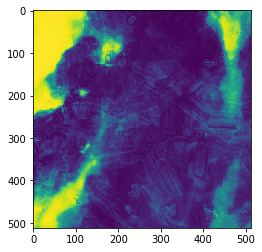

In [166]:
plt.imshow(cloud_probs[0])


In [191]:
cp = cv2.imread(f'{x}-{y}-prob-{date_str}.png')
cp

array([[[ 33, 230, 248],
        [ 31, 230, 246],
        [ 33, 230, 248],
        ...,
        [133, 165,  32],
        [131, 168,  35],
        [130, 170,  36]],

       [[ 33, 230, 248],
        [ 33, 230, 248],
        [ 31, 230, 246],
        ...,
        [132, 167,  34],
        [129, 172,  38],
        [129, 171,  37]],

       [[ 33, 230, 248],
        [ 33, 230, 248],
        [ 31, 230, 246],
        ...,
        [131, 168,  35],
        [121, 182,  51],
        [125, 177,  43]],

       ...,

       [[ 24, 226, 218],
        [ 26, 225, 212],
        [ 33, 223, 197],
        ...,
        [138, 151,  30],
        [141, 138,  34],
        [141, 133,  36]],

       [[ 27, 225, 210],
        [ 28, 225, 207],
        [ 31, 224, 199],
        ...,
        [140, 146,  31],
        [141, 136,  35],
        [141, 139,  34]],

       [[ 29, 224, 205],
        [ 31, 224, 199],
        [ 30, 224, 202],
        ...,
        [141, 140,  33],
        [141, 137,  35],
        [141, 137,  34]]

In [192]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(cp)    
gray/255

array([[0.67900275, 0.67576431, 0.67900275, ..., 0.55002627, 0.55592902,
        0.55980784],
       [0.67900275, 0.67900275, 0.67576431, ..., 0.55435216, 0.56413373,
        0.56138471],
       [0.67900275, 0.67900275, 0.67576431, ..., 0.55592902, 0.58358784,
        0.5731902 ],
       ...,
       [0.64583373, 0.64319373, 0.64008902, ..., 0.52276549, 0.49814471,
        0.48752902],
       [0.64347176, 0.64330275, 0.64094078, ..., 0.51404706, 0.49398784,
        0.50044667],
       [0.64127882, 0.64094078, 0.6411098 , ..., 0.50230157, 0.4962898 ,
        0.49584275]])

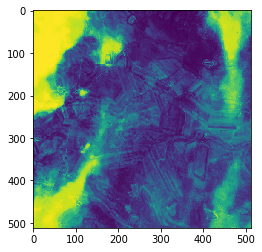

In [199]:
plt.imshow(gray)
#cp

array([[212, 212, 212, ..., 121, 124, 125],
       [212, 212, 212, ..., 123, 127, 126],
       [212, 212, 212, ..., 124, 135, 131],
       ...,
       [200, 198, 193, ..., 113, 107, 104],
       [197, 197, 194, ..., 110, 106, 107],
       [196, 194, 195, ..., 108, 106, 106]], dtype=uint8)

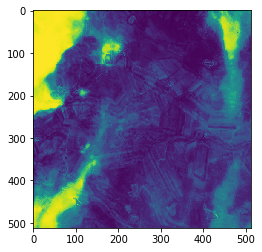

In [201]:
from PIL import Image
from numpy import asarray
image = Image.open(f'{x}-{y}-prob-{date_str}.png')
#plt.imshow(image)
gs_image = image.convert(mode='L')
plt.imshow(gs_image)
asarray(gs_image)

In [36]:
cm = np.array([np.where(cloud_probs[0] > 0.4, 1, 0)])

In [37]:
np.sum(cm[0])

56017

In [26]:
cloud_masks = cloud_detector.get_cloud_masks(np.array(wms_bands))

In [27]:
cloud_masks.shape

(1, 512, 512)

In [28]:
np.sum(cloud_masks[0])

59915

In [38]:
cm.shape

(1, 512, 512)

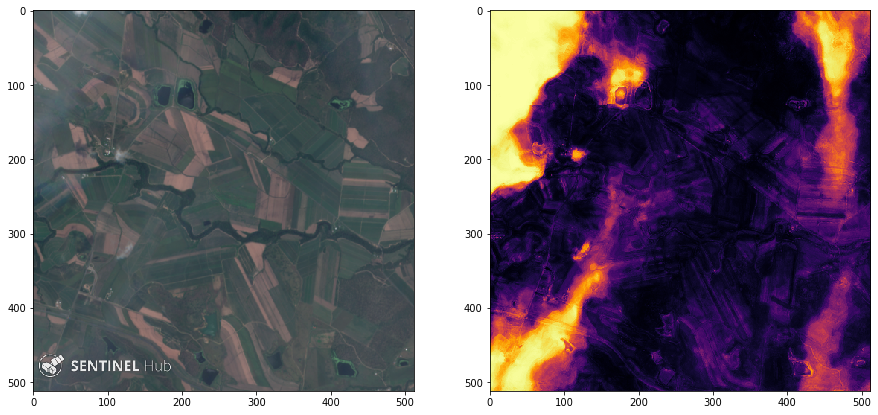

In [49]:
image_idx = 0
plot_probability_map(wms_true_color_imgs[image_idx], cloud_probs[image_idx])

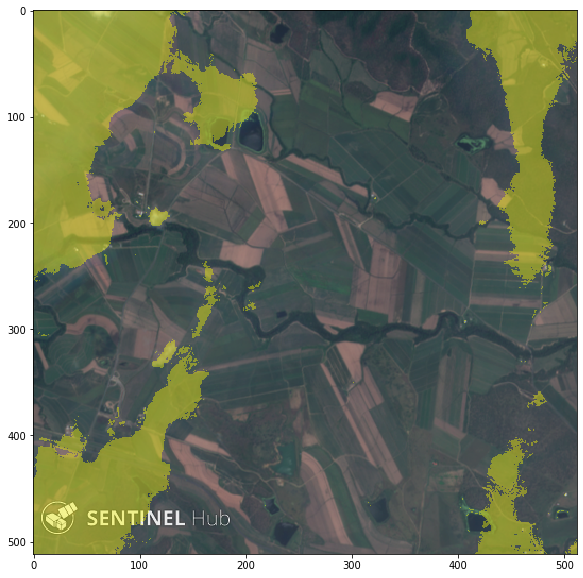

In [44]:
image_idx = 0
overlay_cloud_mask(wms_true_color_imgs[image_idx], cm[image_idx])

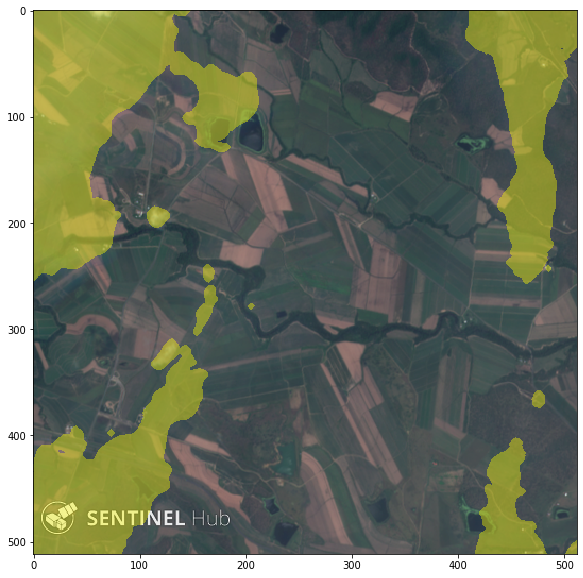

In [45]:
image_idx = 0
overlay_cloud_mask(wms_true_color_imgs[image_idx], cloud_masks[image_idx])

In [26]:
len(wms_bands)

1

In [27]:
wms_bands[0]

array([[[0.1757, 0.1538, 0.1361, ..., 0.0288, 0.2619, 0.1526],
        [0.175 , 0.157 , 0.1408, ..., 0.0288, 0.2552, 0.1452],
        [0.1745, 0.1528, 0.1299, ..., 0.0289, 0.2401, 0.1363],
        ...,
        [0.1542, 0.1284, 0.113 , ..., 0.0186, 0.2589, 0.1364],
        [0.1542, 0.131 , 0.12  , ..., 0.0186, 0.2609, 0.1399],
        [0.1542, 0.1313, 0.1213, ..., 0.0186, 0.262 , 0.1414]],

       [[0.1762, 0.1522, 0.1361, ..., 0.0289, 0.2693, 0.1575],
        [0.1757, 0.1558, 0.1403, ..., 0.0289, 0.2638, 0.1509],
        [0.1752, 0.1508, 0.1287, ..., 0.029 , 0.2496, 0.1426],
        ...,
        [0.1542, 0.1279, 0.1127, ..., 0.0185, 0.2588, 0.1368],
        [0.1542, 0.1297, 0.1172, ..., 0.0185, 0.2609, 0.1405],
        [0.1542, 0.1298, 0.1147, ..., 0.0185, 0.2629, 0.1423]],

       [[0.1767, 0.1536, 0.1374, ..., 0.0289, 0.2761, 0.1613],
        [0.1763, 0.1568, 0.1416, ..., 0.0289, 0.2697, 0.155 ],
        [0.1759, 0.1509, 0.1295, ..., 0.029 , 0.2569, 0.147 ],
        ...,
        [0.1